# Neural Nets with Keras

# Imports

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras  # tf.keras
import time
from functools import partial
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.7.2 (default, Dec 29 2018, 00:00:04) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
matplotlib 3.0.3
numpy 1.16.2
pandas 0.24.2
sklearn 0.20.3
tensorflow 2.0.0-alpha0
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [5]:
assert sys.version_info >= (3, 6) # Python ≥3.6 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

# Plot functions

In [6]:
def _default(def_dict, user_dict):
    if user_dict is None:
        user_dict = {}
    return {**def_dict, **user_dict}

def plot_learning_curves(history, title=None, axes=None, plot_kw=None):
    # This plot accepts both an History obj or
    # a dict like History.history
    if hasattr(history, 'history'):
        history = history.history
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    else:
        assert len(axes) == 2
        fig = axes[0].figure
    df = pd.DataFrame(history)
    plot_kw = _default(dict(marker='o', ms='4'), plot_kw)
    df[['loss', 'val_loss']].plot(ax=axes[0], **plot_kw)
    df[['accuracy', 'val_accuracy']].plot(ax=axes[1], **plot_kw)
    for ax in axes:
        ax.grid(True)
        ax.set_xlabel('Epochs')
        ax.set_xlim(-0.25, df.shape[0] - 0.75)
    y_th = 0.6
    frac = 0.3
    ymin = y_th if (df.accuracy > y_th).sum() > frac*df.shape[0] else 0
    axes[1].set_ylim(ymin, 1);
    axes[0].set_title('Loss')
    axes[1].set_title(f'Accuracy, max(val_acc) = {df.val_accuracy.max():.3f} @ {df.val_accuracy.idxmax()}')
    axes[1].axvline(df.val_accuracy.idxmax(), color='k', ls='--')
    if title is not None:
        fig.suptitle(title)
        
def plot_weights(history, axes=None, hist_kw=None):
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    else:
        assert len(axes) == 2
        fig = axes[0].figure
    model = history.model
    hist_kw = _default(dict(bins=80, histtype='step', density=True), hist_kw)
    for la in model.layers:
        params = la.get_weights()
        if len(params) == 1:
            w, b = params[0], np.array([])
        elif len(params) == 2:
            w, b = params
        else:
            continue
        axes[0].hist(w.ravel(), label=la.name, **hist_kw);
        axes[1].hist(b.ravel(), label=la.name, **hist_kw);
    axes[1].legend();
    axes[0].set_xlabel('weights')
    axes[1].set_xlabel('bias')
    for ax in axes: ax.grid(True)

# Load the Fashion MNIST dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [52]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = (
    fashion_mnist.load_data())
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

The training set contains 55,000 grayscale images, each 28x28 pixels:

In [53]:
X_train.shape, X_valid.shape, X_test.shape

((55000, 28, 28), (5000, 28, 28), (10000, 28, 28))

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

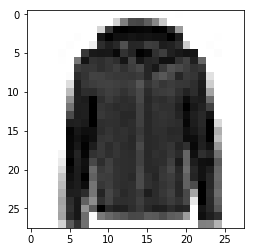

In [54]:
plt.imshow(X_train[0], cmap="binary");

The labels are the class IDs (represented as uint8), from 0 to 9:

In [55]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [56]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [57]:
X_valid.shape

(5000, 28, 28)

In [58]:
X_test.shape

(10000, 28, 28)

In [60]:
input_shape = (28, 28, 1)
X_train_full = X_train_full.reshape(X_train_full.shape[0], *input_shape)
X_train = X_train.reshape(X_train.shape[0], *input_shape)
X_test = X_test.reshape(X_test.shape[0], *input_shape)
X_valid = X_valid.reshape(X_valid.shape[0], *input_shape)

In [61]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full.astype(np.float32).reshape(-1, 1)).reshape(-1, *input_shape)
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 1)).reshape(-1, *input_shape)
X_valid_scaled = scaler.transform(X_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, *input_shape)
X_test_scaled = scaler.transform(X_test.astype(np.float32).reshape(-1, 1)).reshape(-1, *input_shape)
X_test_scaled.shape, X_test_scaled.dtype

((10000, 28, 28, 1), dtype('float32'))

In [62]:
X_train_scaled.min(), X_train_scaled.max()

(-0.8105139, 2.023144)

In [68]:
X_train_full.shape[0] * 0.084

5040.0

# ImageDataGenerator

In [69]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    #zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    #brightness_range=(0.9, 1),
    dtype='float',
    rescale=1/255,
    validation_split=0.084,
    )

batches = datagen.flow(X_train_full, y_train_full, batch_size=25)

x_batch, y_batch = next(batches)
print(f'x_batch.shape: {x_batch.shape}, y_batch.shape: {y_batch.shape}')
print(f'x_batch.max(): {x_batch.max()}, x_batch.min(): {x_batch.min()}, \nunique(y_train): {np.unique(y_train)}')

x_batch.shape: (25, 28, 28, 1), y_batch.shape: (25,)
x_batch.max(): 1.0, x_batch.min(): 0.0, 
unique(y_train): [0 1 2 3 4 5 6 7 8 9]


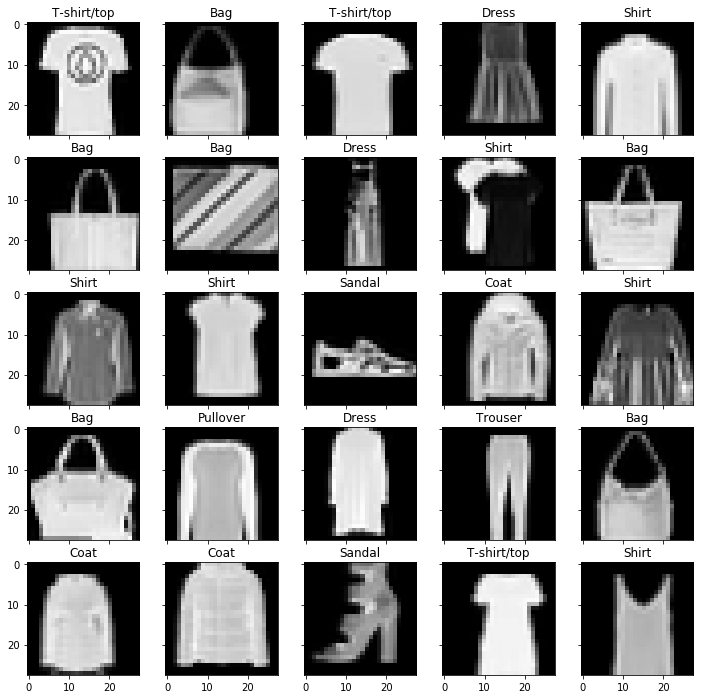

In [70]:
fig, ax = plt.subplots(5, 5, figsize=(12, 12), sharex=True, sharey=True)
for i, a in enumerate(ax.ravel()):
    a.imshow(x_batch[i].reshape(28, 28), cmap='gray', vmin=0, vmax=1)
    a.set_title(class_names[y_batch[i]])
    a.grid(False)

# ConvNet

In [76]:
kernel_init = "he_normal"
batch_size = 256
epochs = 10
lr = 1e-3
activation="relu"
nesterov = True
optim = keras.optimizers.Nadam(lr)

model_name = (f'{optim.__class__.__name__}(lr={lr:.1g}) (100, 50, 10), scaled input, '
              f'batch_size = {batch_size}, {kernel_init}, {activation} '
             )
HiddenDense = partial(keras.layers.Dense,
                      activation=activation, 
                      kernel_initializer=kernel_init,
                     )
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28,1]),
    HiddenDense(100),
    HiddenDense(50),
    keras.layers.Dense(10, activation="softmax", 
                       kernel_initializer='glorot_uniform',
                       ),
    ],
    name=model_name)
model.compile(optimizer=optim, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
print(model_name)
history = model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid))

Nadam(lr=0.001) (100, 50, 10), scaled input, batch_size = 256, he_normal, relu 
Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 2s 33us/sample - loss: 0.5649 - accuracy: 0.8003 - val_loss: 0.3998 - val_accuracy: 0.8558
Epoch 2/10
55000/55000 [==============================] - 2s 33us/sample - loss: 0.3823 - accuracy: 0.8603 - val_loss: 0.3542 - val_accuracy: 0.8728
Epoch 3/10
55000/55000 [==============================] - 1s 23us/sample - loss: 0.3388 - accuracy: 0.8757 - val_loss: 0.3363 - val_accuracy: 0.8782
Epoch 4/10
55000/55000 [==============================] - 1s 23us/sample - loss: 0.3128 - accuracy: 0.8854 - val_loss: 0.3363 - val_accuracy: 0.8780
Epoch 5/10
55000/55000 [==============================] - 1s 22us/sample - loss: 0.2901 - accuracy: 0.8937 - val_loss: 0.3685 - val_accuracy: 0.8654
Epoch 6/10
55000/55000 [==============================] - 1s 23us/sample - loss: 0.2753 - accuracy: 0.8977 - val_loss: 0.3162 

Model: "Nadam(lr=0.001) (100, 50, 10), scaled input, batch_size = 256, he_normal, relu "
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_19 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_20 (Dense)             (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


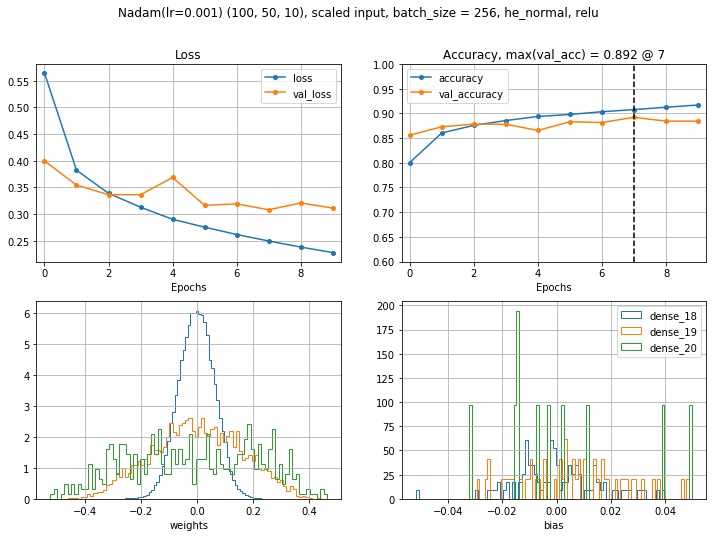

In [77]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, axes=Ax[0])
plot_weights(history, axes=Ax[1])
fig.suptitle(model_name)
model.summary()

In [78]:
test_loss, test_acc = model.evaluate(X_test / 255, y_test)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 1s 75us/sample - loss: 0.9738 - accuracy: 0.7714s - loss: 0.9817 - accu
Test accuracy: 0.7714


In [73]:
kernel_init = "he_normal"
batch_size = 256
epochs = 10
lr = 1e-3
activation="relu"
nesterov = True
optim = keras.optimizers.Nadam(lr)

model_name = (f'{optim.__class__.__name__}(lr={lr:.1g}) (100, 50, 10), scaled input, '
              f'batch_size = {batch_size}, {kernel_init}, {activation} '
             )
HiddenDense = partial(keras.layers.Dense,
                      activation=activation, 
                      kernel_initializer=kernel_init,
                     )
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28,1]),
    HiddenDense(100),
    HiddenDense(50),
    keras.layers.Dense(10, activation="softmax", 
                       kernel_initializer='glorot_uniform',
                       ),
    ],
    name=model_name)
model.compile(optimizer=optim, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
print(model_name)

train_generator = datagen.flow(X_train_full, y_train_full, 
                               batch_size=batch_size, subset='training')
valid_generator = datagen.flow(X_train_full, y_train_full, 
                               batch_size=batch_size, subset='validation')

history = model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    steps_per_epoch=len(y_train) / batch_size, epochs=epochs)

Nadam(lr=0.001) (100, 50, 10), scaled input, batch_size = 256, he_normal, relu 
Epoch 1/10
215/214 [==============================] - 16s 75ms/step - loss: 0.9402 - accuracy: 0.6645 - val_loss: 0.6876 - val_accuracy: 0.7540
Epoch 2/10
215/214 [==============================] - 19s 87ms/step - loss: 0.6652 - accuracy: 0.7563 - val_loss: 0.6080 - val_accuracy: 0.7819
Epoch 3/10
215/214 [==============================] - 17s 80ms/step - loss: 0.6126 - accuracy: 0.7764 - val_loss: 0.5739 - val_accuracy: 0.7972
Epoch 4/10
215/214 [==============================] - 14s 66ms/step - loss: 0.5727 - accuracy: 0.7920 - val_loss: 0.5282 - val_accuracy: 0.8137
Epoch 5/10
215/214 [==============================] - 16s 74ms/step - loss: 0.5467 - accuracy: 0.8024 - val_loss: 0.5315 - val_accuracy: 0.8069
Epoch 6/10
215/214 [==============================] - 16s 74ms/step - loss: 0.5280 - accuracy: 0.8090 - val_loss: 0.5325 - val_accuracy: 0.8085
Epoch 7/10
215/214 [==============================] - 19

Model: "Nadam(lr=0.001) (100, 50, 10), scaled input, batch_size = 256, he_normal, relu "
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_16 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_17 (Dense)             (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


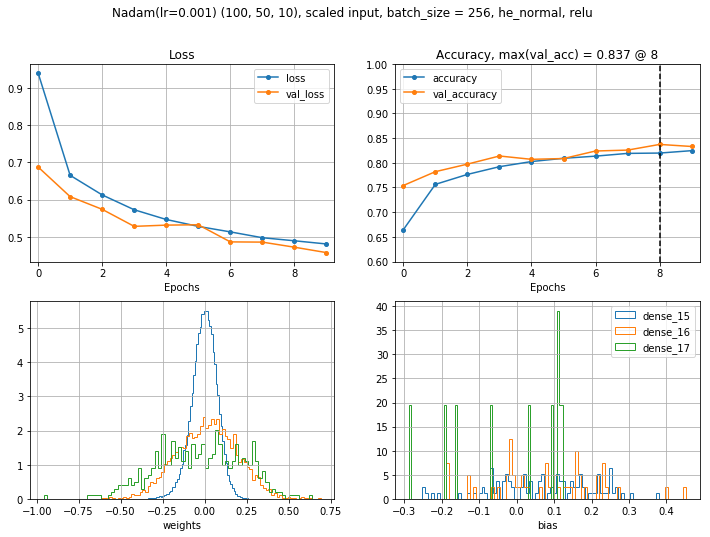

In [74]:
fig, Ax = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(history, axes=Ax[0])
plot_weights(history, axes=Ax[1])
fig.suptitle(model_name)
model.summary()

In [75]:
test_loss, test_acc = model.evaluate(X_test / 255, y_test)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 0s 48us/sample - loss: 0.4614 - accuracy: 0.8326
Test accuracy: 0.8326
